Подготова датасета

In [ ]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [85]:
# Загрузка датасета
file_path = "phone.csv"  # Укажите имя файла, если он находится в той же папке
dk = pd.read_csv(file_path)
cols=['battery_power', 'px_height', 'px_width', 'ram', 'price_range']
df=dk[cols]
df.head()

,battery_power,px_height,px_width,ram,price_range
0,842,20,756,2549,1
1,1021,905,1988,2631,2
2,563,1263,1716,2603,2
3,615,1216,1786,2769,2
4,1821,1208,1212,1411,1


In [89]:
# Присваиваем X все столбцы, кроме целевой переменной
X = df.drop(columns=["price_range"])

# Присваиваем y целевую переменную
y = df["price_range"]

# Проверяем значения целевой переменной
print(y.value_counts())

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


K-Means

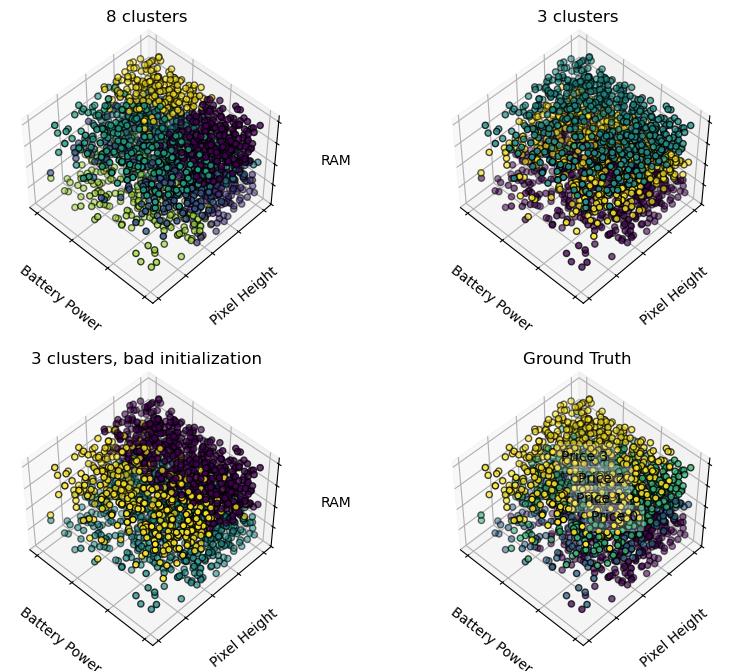

In [91]:
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans

# Задаем параметры для KMeans
estimators = [
    ("k_means_phone_8", KMeans(n_clusters=8)),
    ("k_means_phone_3", KMeans(n_clusters=3)),
    ("k_means_phone_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]

for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    # Используем подходящие колонки для визуализации
    ax.scatter(
        X["battery_power"],
        X["px_height"],
        X["ram"],
        c=labels.astype(float),
        edgecolor="k"
    )

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Battery Power")
    ax.set_ylabel("Pixel Height")
    ax.set_zlabel("RAM")
    ax.set_title(title)

# Ground Truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for price, label in zip(y.unique(), range(len(y.unique()))):
    ds = df[df["price_range"] == price]
    ax.text3D(
        ds["battery_power"].mean(),
        ds["px_height"].mean(),
        ds["ram"].mean(),
        f"Price {price}",
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(
    X["battery_power"],
    X["px_height"],
    X["ram"],
    c=y,
    edgecolor="k"
)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Battery Power")
ax.set_ylabel("Pixel Height")
ax.set_zlabel("RAM")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()


Метрики

In [95]:
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans

# Диапазон количества кластеров
n_clusters = np.arange(2, 21)

# Инициализация метрик
best_metric = [0, float("inf"), 0, []]
silhouette_score_values = []
adjusted_rand_score_values = []

# Цикл по количеству кластеров
for n in n_clusters:
    # Инициализация и обучение модели KMeans
    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10, random_state=42)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)

    # Расчет метрик
    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)

    score2 = adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)

    # Обновление лучших метрик
    if score1 < best_metric[1] and score2 > best_metric[2]:
        best_metric[1] = score1
        best_metric[2] = score2
        best_metric[3] = clusterer.cluster_centers_
        best_metric[0] = n

# Вывод лучших метрик
print("Лучшие метрики для кластеризации:")
print(f"Количество кластеров: {best_metric[0]}")
print(f"Silhouette Score: {best_metric[1]:.4f}")
print(f"Adjusted Rand Score: {best_metric[2]:.4f}")
print("Центры кластеров:", best_metric[3])


Лучшие метрики для кластеризации:
Количество кластеров: 4
Silhouette Score: 0.2666
Adjusted Rand Score: 0.4660
Центры кластеров: [[1239.76        645.6        1283.885      3436.91      ]
 [1239.57415254  394.85805085 1006.19067797 2274.74576271]
 [1238.45923461  560.95174709 1192.58569052  840.35108153]
 [1234.82568807 1160.09480122 1654.5382263  1857.94801223]]


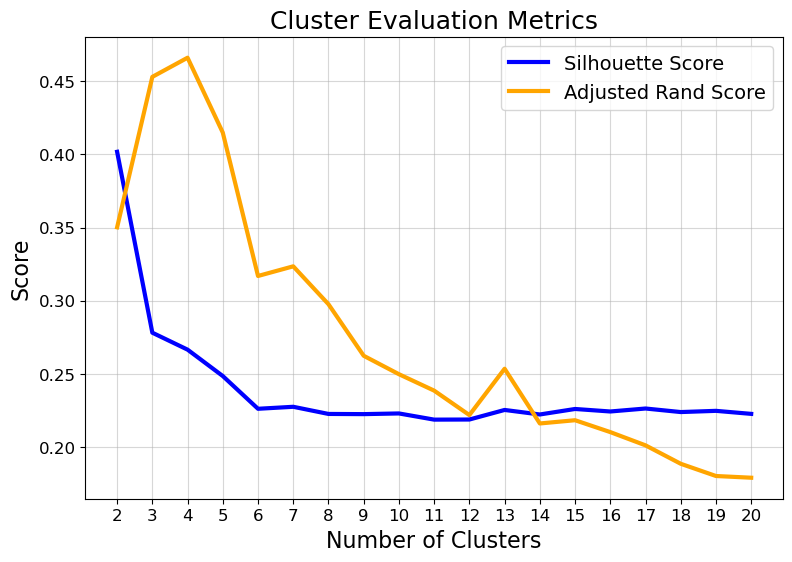

In [97]:
plt.figure(figsize=(9, 6))

# Построение графиков для Silhouette Score и Adjusted Rand Score
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette Score', color='blue')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted Rand Score', color='orange')

# Подписи и оформление
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(n_clusters, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Cluster Evaluation Metrics', fontsize=18)
plt.legend(loc='best', fontsize=14)

# Показ графика
plt.grid(alpha=0.5)
plt.show()


Иерархическая кластеризация

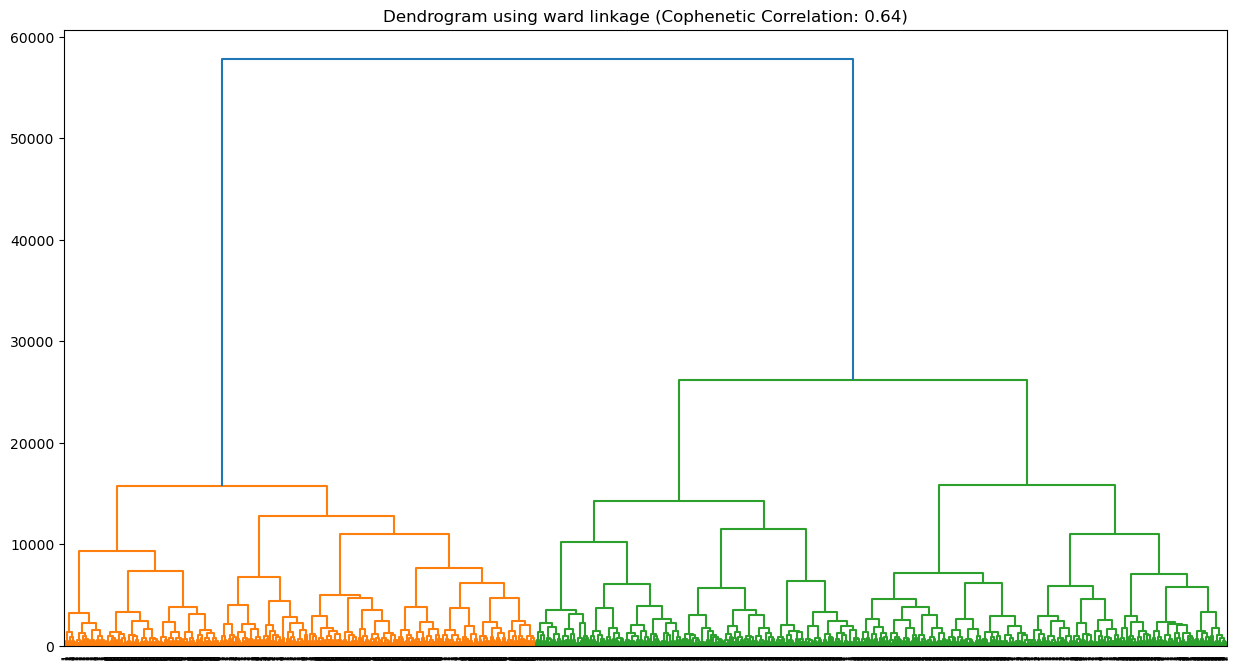

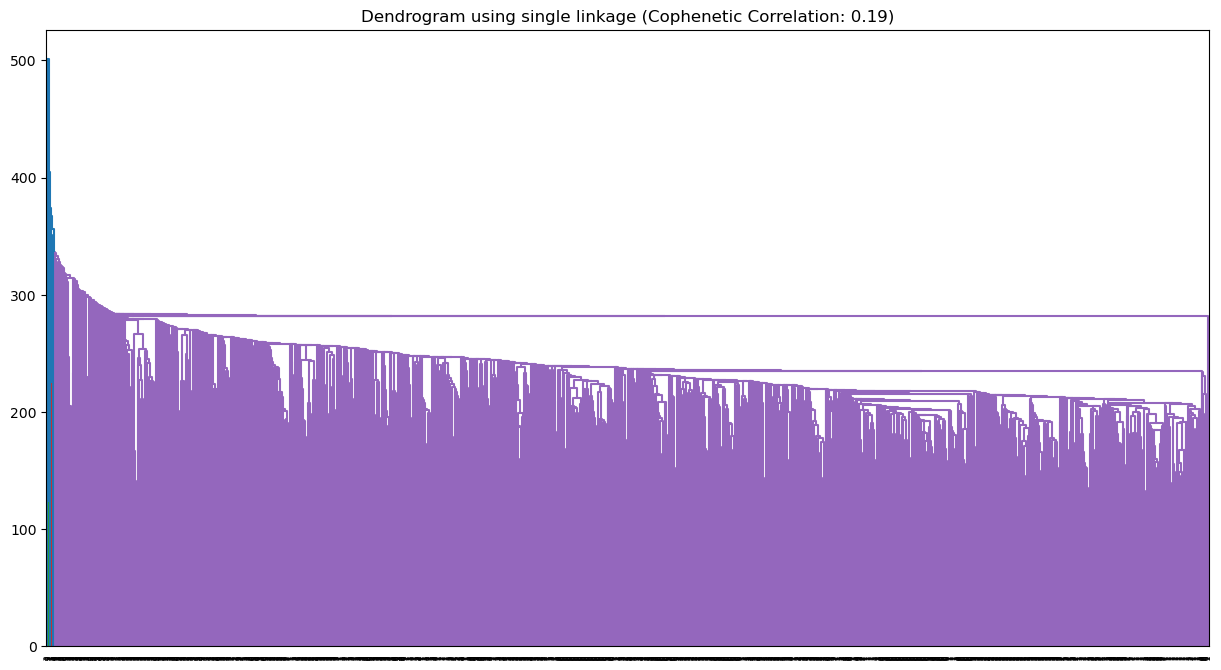

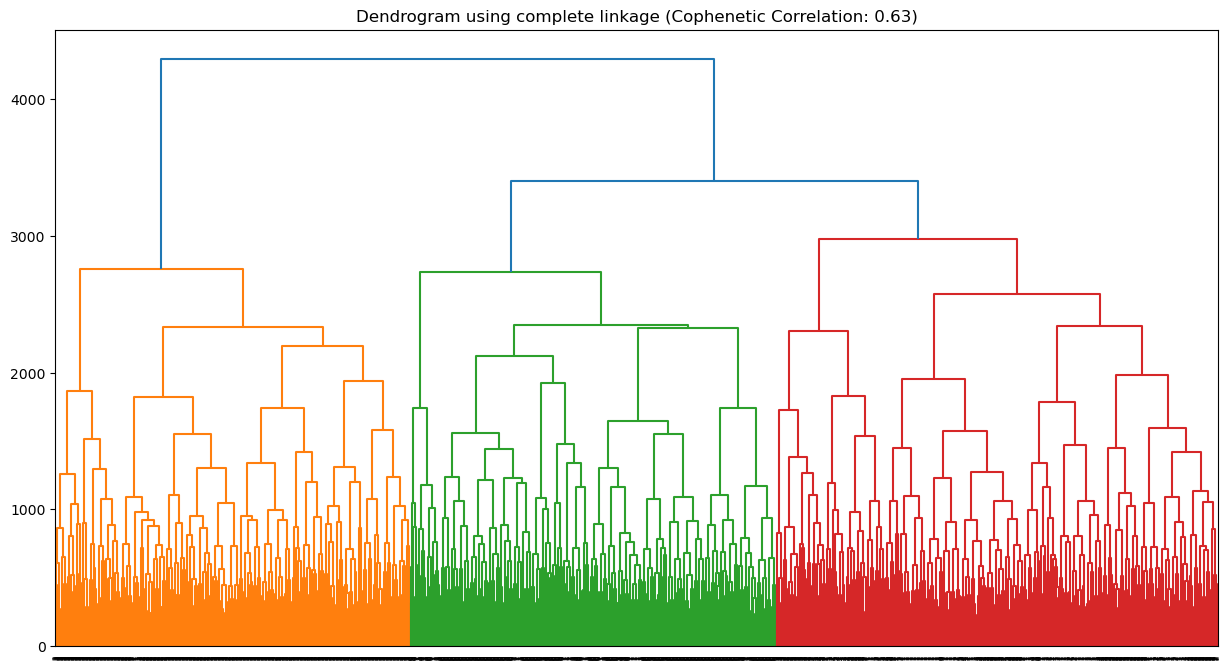

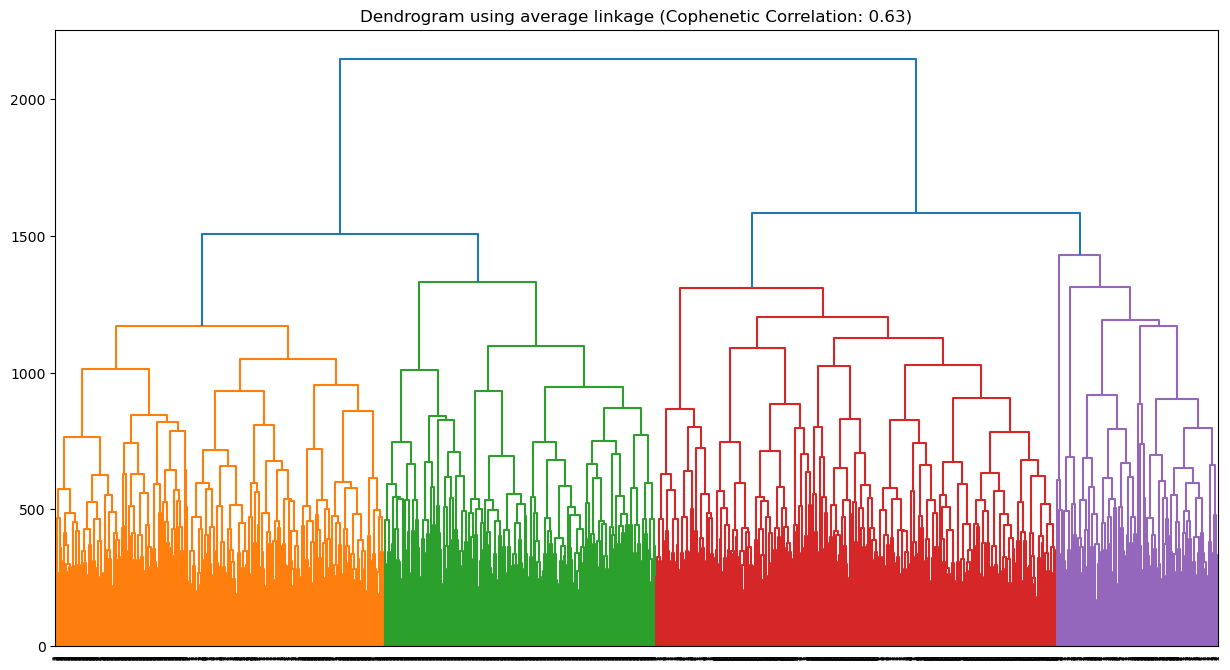

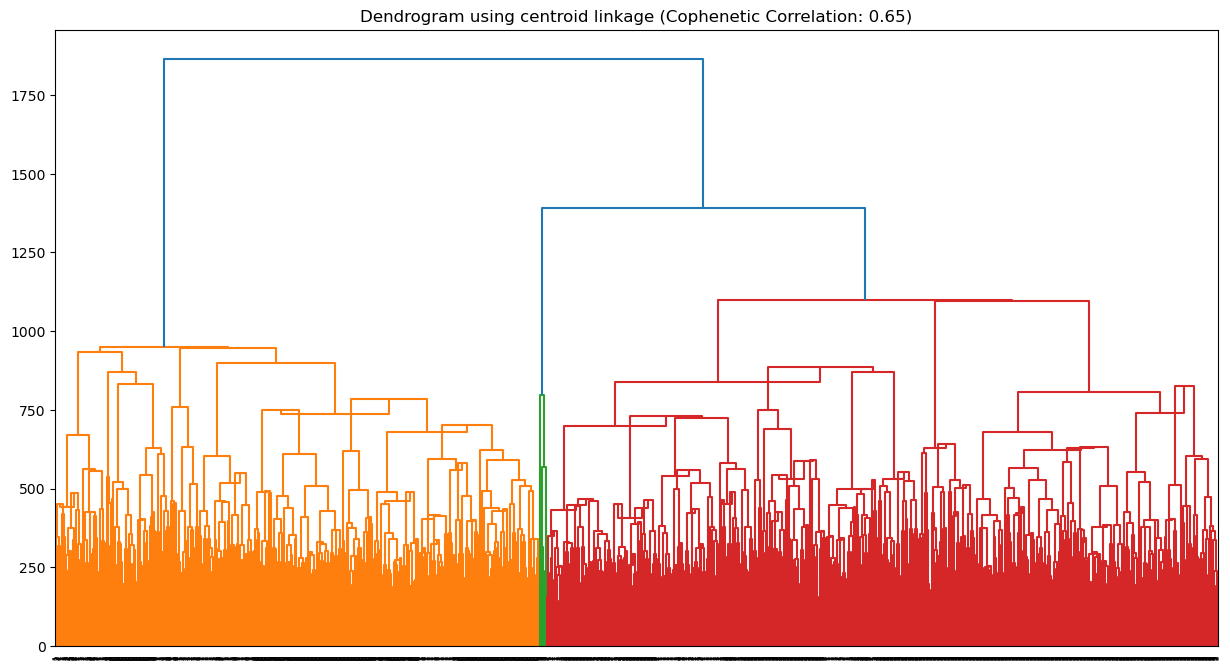

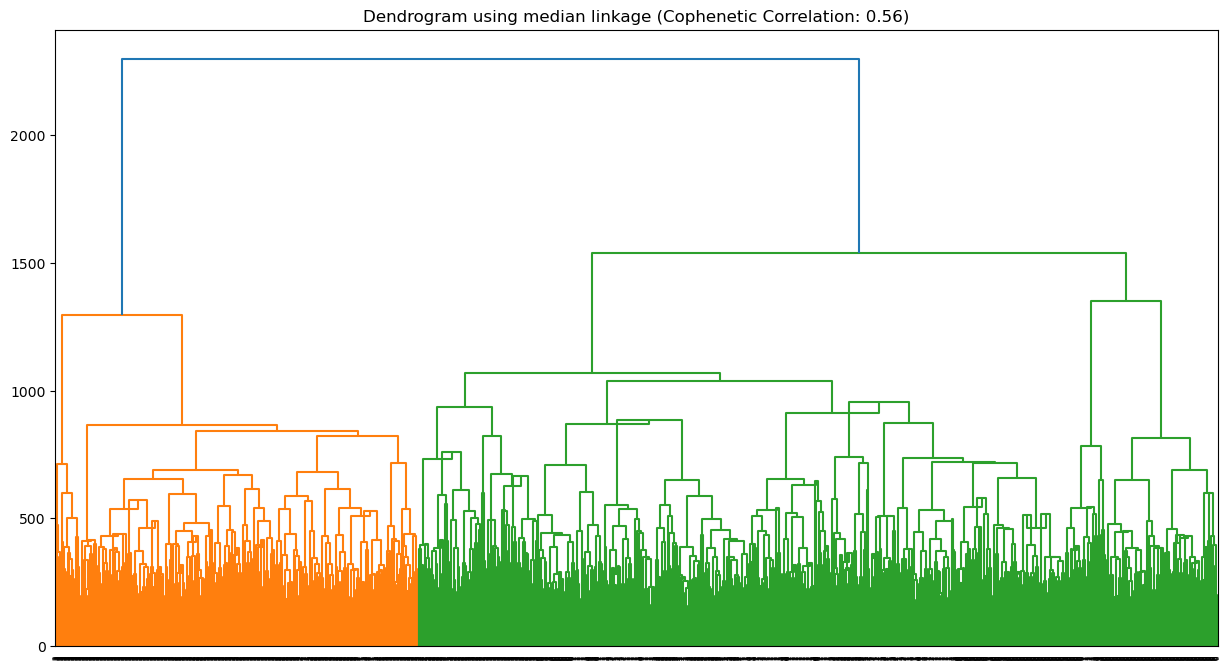

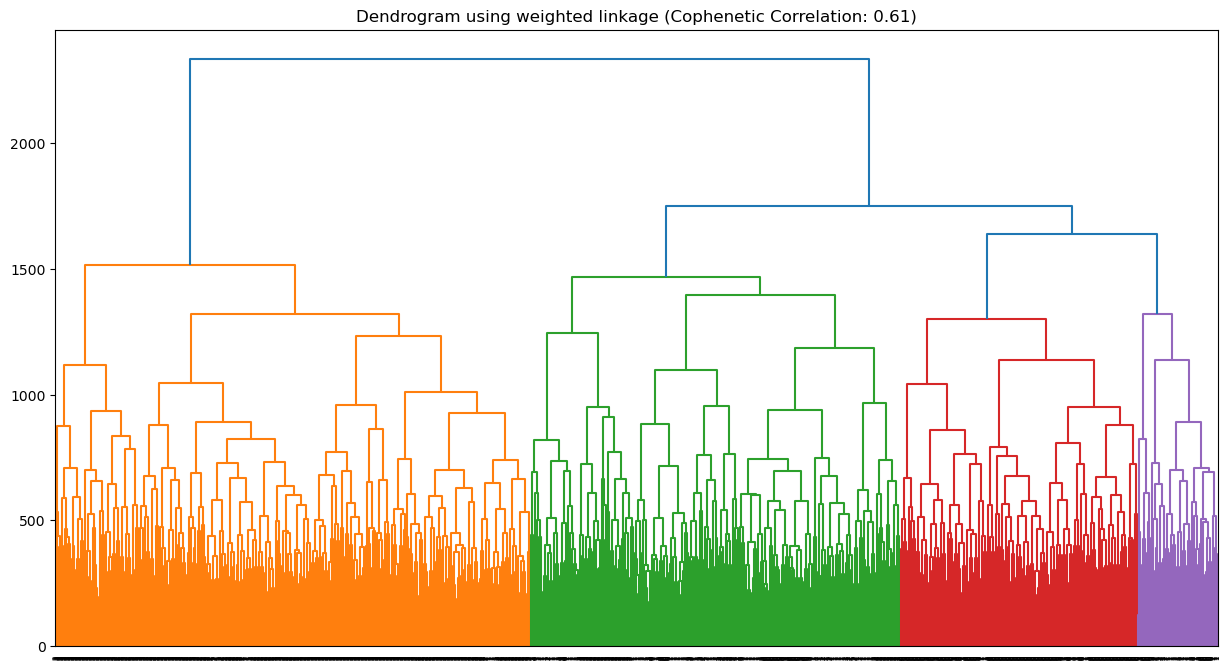

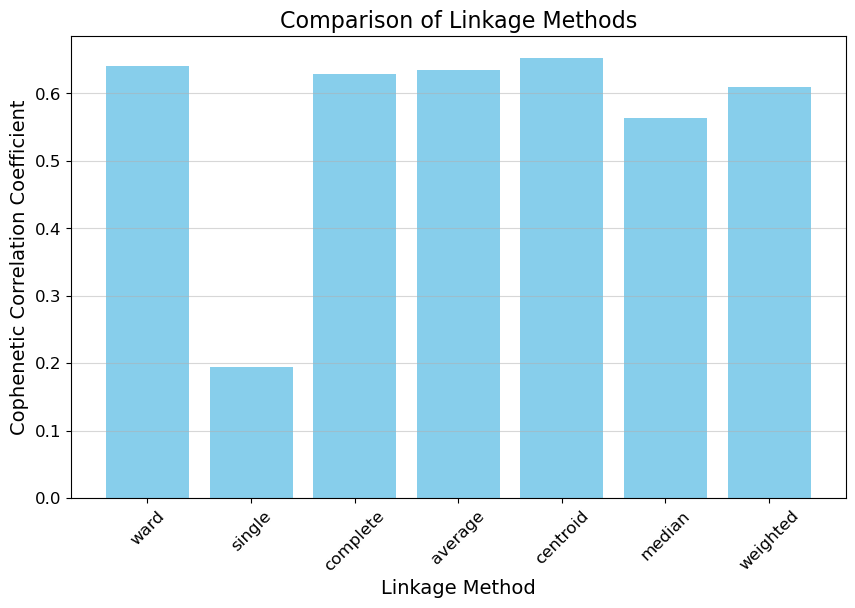

Лучший метод кластеризации: centroid с Cophenetic Correlation: 0.65


In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Преобразуем данные в массив
samples = X.values

# Методы кластеризации для сравнения
methods = ["ward", "single", "complete", "average", "centroid", "median", "weighted"]

# Словарь для хранения метрик
cophenetic_scores = {}

# Построение дендрограмм для каждого метода
for method in methods:
    plt.figure(figsize=(15, 8))
    # Реализация иерархической кластеризации
    mergings = linkage(samples, method=method)
    coph_corr, _ = cophenet(mergings, pdist(samples))
    cophenetic_scores[method] = coph_corr  # Сохраняем метрику
    
    # Построение дендрограммы
    plt.title(f"Dendrogram using {method} linkage (Cophenetic Correlation: {coph_corr:.2f})")
    dendrogram(mergings,
               labels=list(y),
               leaf_rotation=90,
               leaf_font_size=5)
    plt.show()

# Сравнение метрик качества
plt.figure(figsize=(10, 6))
plt.bar(cophenetic_scores.keys(), cophenetic_scores.values(), color='skyblue')
plt.xlabel("Linkage Method", fontsize=14)
plt.ylabel("Cophenetic Correlation Coefficient", fontsize=14)
plt.title("Comparison of Linkage Methods", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", alpha=0.5)
plt.show()

# Вывод лучших результатов
best_method = max(cophenetic_scores, key=cophenetic_scores.get)
print(f"Лучший метод кластеризации: {best_method} с Cophenetic Correlation: {cophenetic_scores[best_method]:.2f}")


DBSCAN

Количество кластеров (без учета шума): 12
Homogeneity Score: 0.1244
Completeness Score: 0.1912
Silhouette Score: -0.2668


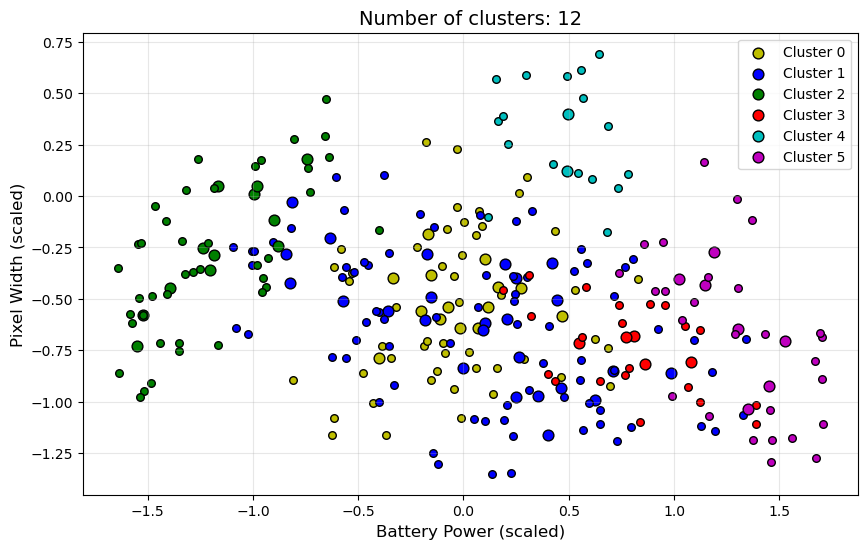

In [105]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение модели DBSCAN
db = DBSCAN(eps=0.5, min_samples=12).fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Количество кластеров (исключая шум, обозначенный как -1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Вывод результатов
print(f"Количество кластеров (без учета шума): {n_clusters_}")
print(f"Homogeneity Score: {metrics.homogeneity_score(y, labels):.4f}")
print(f"Completeness Score: {metrics.completeness_score(y, labels):.4f}")
print(f"Silhouette Score: {metrics.silhouette_score(X_scaled, labels):.4f}")

# Визуализация
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r', 'c', 'm']  # Расширенные цвета для кластеров

plt.figure(figsize=(10, 6))
X_array = X_scaled  # Преобразуем DataFrame в массив для индексации
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный цвет для шума
        col = 'k'

    class_member_mask = (labels == k)

    # Точки, относящиеся к ядру кластеров
    xy_core = X_array[class_member_mask & core_samples_mask]
    plt.scatter(
        xy_core[:, 0], xy_core[:, 1],
        c=col, edgecolor='k', label=f"Cluster {k}" if k != -1 else "Noise", s=60
    )

    # Точки, относящиеся к периферии кластеров
    xy_periphery = X_array[class_member_mask & ~core_samples_mask]
    plt.scatter(
        xy_periphery[:, 0], xy_periphery[:, 1],
        c=col, edgecolor='k', s=30
    )

plt.title(f'Number of clusters: {n_clusters_}', fontsize=14)
plt.xlabel('Battery Power (scaled)', fontsize=12)
plt.ylabel('Pixel Width (scaled)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


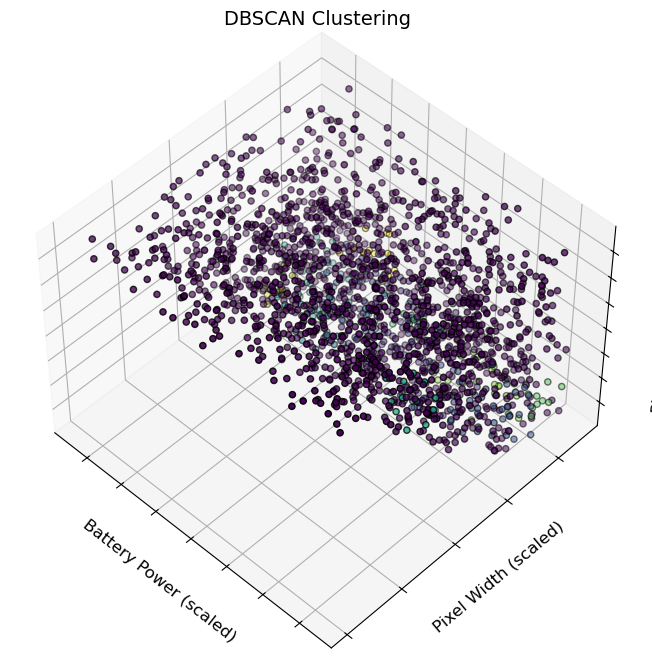

In [107]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d", elev=48, azim=134)

# Используем преобразованные данные для визуализации
ax.scatter(
    X_scaled[:, 0],  # Признак: battery_power (нормализованный)
    X_scaled[:, 1],  # Признак: px_width (нормализованный)
    X_scaled[:, 2],  # Признак: px_height (нормализованный)
    c=labels.astype(float), edgecolor="k"
)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Battery Power (scaled)", fontsize=12)
ax.set_ylabel("Pixel Width (scaled)", fontsize=12)
ax.set_zlabel("Pixel Height (scaled)", fontsize=12)
ax.set_title("DBSCAN Clustering", fontsize=14)

plt.show()


In [109]:
# evaluation metrics
sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index: %0.2f" % ari)

Silhouette Coefficient:-0.34
Adjusted Rand Index: 0.01
